In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.filters import sobel
from skimage.feature import canny
from scipy.ndimage import distance_transform_edt

In [6]:
# Read the images
image1 = img_as_float(io.imread('ball.png', as_gray=True))
image2 = img_as_float(io.imread('coffee.png', as_gray=True))

In [7]:
# Initialize the snake
s = np.linspace(0, 2*np.pi, 400)
x = 220 + 100*np.cos(s)
y = 100 + 100*np.sin(s)
init = np.array([x, y]).T

In [8]:
def external_energy(image):
    edges = canny(image, sigma=2)
    dist = distance_transform_edt(~edges)
    return -dist

In [9]:
def gradient_energy(image):
    grad = sobel(image)
    return -grad

In [10]:
def internal_energy(snake, alpha=0.1, beta=0.1):
    dists = np.sqrt(np.sum(np.diff(snake, axis=0)**2, axis=1))
    avg_dist = np.mean(dists)
    elastic_energy = alpha * np.sum((dists - avg_dist)**2)
    bending_energy = beta * np.sum(np.diff(snake, n=2, axis=0)**2)
    return elastic_energy + bending_energy


In [11]:
def viterbi_snake(image, init, alpha=0.1, beta=0.1, gamma=0.1, max_iter=500, tol=1e-3):
    snake = init.copy()
    ext_energy = external_energy(image) + gradient_energy(image)
    for _ in range(max_iter):
        prev_snake = snake.copy()
        for i in range(1, len(snake) - 1):
            neighborhood = np.array([[dx, dy] for dx in range(-1, 2) for dy in range(-1, 2)])
            new_positions = snake[i] + neighborhood
            new_positions = np.clip(new_positions, 0, np.array(image.shape) - 1)
            energies = np.array([internal_energy(np.vstack([snake[:i], pos, snake[i+1:]]), alpha, beta) + gamma * ext_energy[int(pos[1]), int(pos[0])] for pos in new_positions])
            min_energy_idx = np.argmin(energies)
            snake[i] = new_positions[min_energy_idx]
        if np.linalg.norm(snake - prev_snake) < tol:
            break
    return snake

In [12]:
# Apply snake to both images
snake1 = viterbi_snake(image1, init, alpha=0.1, beta=0.1, gamma=1.0)
snake2 = viterbi_snake(image2, init, alpha=0.1, beta=0.1, gamma=1.0)

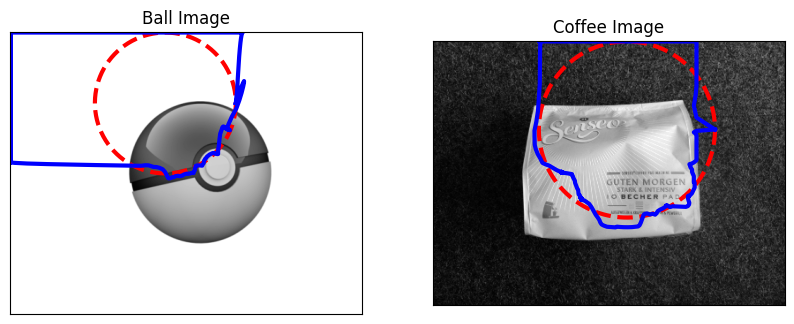

In [19]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image1, cmap=plt.cm.gray)
ax[0].plot(init[:, 0], init[:, 1], '--r', lw=3)
ax[0].plot(snake1[:, 0], snake1[:, 1], '-b', lw=3)
ax[0].set_title('Ball Image')
ax[1].imshow(image2, cmap=plt.cm.gray)
ax[1].plot(init[:, 0], init[:, 1], '--r', lw=3)
ax[1].plot(snake2[:, 0], snake2[:, 1], '-b', lw=3)
ax[1].set_title('Coffee Image')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.show()